In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import os
import torch
from kan import KAN
import time

import warnings
import sys

# Environment variables to suppress CUDA warnings
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

# Python warnings suppression
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Specific CUDA-related warnings
warnings.filterwarnings("ignore", message=".*CUDA.*")
warnings.filterwarnings("ignore", message=".*cudaGetDeviceCount.*")
warnings.filterwarnings("ignore", module="torch.*")

# Suppress stdout/stderr for CUDA initialization
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr


##### Loading the inference model and functions

In [4]:
################################setup######################################
def load_csv_data(input_folder: str,
                  train_fname: str,
                  test_fname: str):
    """
    Reads train & test CSVs from disk.
    
    Returns:
      train_df, test_df (both pandas.DataFrame)
    """
    train_path = os.path.join(input_folder, train_fname)
    test_path  = os.path.join(input_folder, test_fname)
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
    return train_df, test_df


def extract_features_labels(df: pd.DataFrame):
    """
    Splits a DataFrame into numpy feature array X and label vector y.
    
    The last column is the label.
    """
    X = df.iloc[:, :-1].values
    y = df.iloc[:,  -1].values
    return X, y

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]
            ############################################################
            # Check if any class is missing in the batch
            # present_classes = np.unique(labels.cpu().numpy())
            # all_classes = np.arange(len(label_mapping))  # Adjust based on number of classes
            # missing_classes = set(all_classes) - set(present_classes)
            #
            # if missing_classes:
            #     print(f"Batch {start_idx // self.batch_size} is missing classes {missing_classes}")
            ############################################################
            yield data, labels


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """

    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)  # 计算并返回与给定类标签l对应的概率值
        return out


class MLP(torch.nn.Module):
    """
    This model returns the logits for the classes given an input example. It does not compute the softmax, so the output
    are not normalized.
    This is done to separate the accuracy computation from the satisfaction level computation. Go through the example
    to understand it.
    """

    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        """
        Method which defines the forward phase of the neural network for our multi class classification task.
        In particular, it returns the logits for the classes given an input example.

        :param x: the features of the example
        :param training: whether the network is in training mode (dropout applied) or validation mode (dropout not applied)
        :return: logits for example x
        """
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits


class MultiKANModel(torch.nn.Module):
    def __init__(self, kan):
        """
        Wrap an already built MultKAN instance.
        Args:
            kan: a MultKAN model (which has attributes such as act_fun, symbolic_fun, node_bias, node_scale,
                 subnode_bias, subnode_scale, depth, width, mult_homo, mult_arity, input_id, symbolic_enabled, etc.)
        """
        super(MultiKANModel, self).__init__()
        self.kan = kan

    def forward(self, x, training=False, singularity_avoiding=False, y_th=10.):
        # Select input features according to input_id
        x = x[:, self.kan.input_id.long()]
        # Loop through each layer
        for l in range(self.kan.depth):
            # Get outputs from the numerical branch (KANLayer) of current layer
            x_numerical, preacts, postacts_numerical, postspline = self.kan.act_fun[l](x)
            # Get output from the symbolic branch if enabled
            if self.kan.symbolic_enabled:
                x_symbolic, postacts_symbolic = self.kan.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
            # Sum the numerical and symbolic outputs
            x = x_numerical + x_symbolic

            # Subnode affine transformation
            x = self.kan.subnode_scale[l][None, :] * x + self.kan.subnode_bias[l][None, :]

            # Process multiplication nodes
            dim_sum = self.kan.width[l+1][0]
            dim_mult = self.kan.width[l+1][1]
            if dim_mult > 0:
                if self.kan.mult_homo:
                    for i in range(self.kan.mult_arity-1):
                        if i == 0:
                            x_mult = x[:, dim_sum::self.kan.mult_arity] * x[:, dim_sum+1::self.kan.mult_arity]
                        else:
                            x_mult = x_mult * x[:, dim_sum+i+1::self.kan.mult_arity]
                else:
                    for j in range(dim_mult):
                        acml_id = dim_sum + int(np.sum(self.kan.mult_arity[l+1][:j]))
                        for i in range(self.kan.mult_arity[l+1][j]-1):
                            if i == 0:
                                x_mult_j = x[:, [acml_id]] * x[:, [acml_id+1]]
                            else:
                                x_mult_j = x_mult_j * x[:, [acml_id+i+1]]
                        if j == 0:
                            x_mult = x_mult_j
                        else:
                            x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                # Concatenate sum and mult parts
                x = torch.cat([x[:, :dim_sum], x_mult], dim=1)

            # Node affine transformation
            x = self.kan.node_scale[l][None, :] * x + self.kan.node_bias[l][None, :]

        # Final x corresponds to the logits output of the whole model
        return x


def save_model(model, model_save_folder, model_name):
    """
    Save the model to disk.
    """
    torch.save(model.state_dict(), os.path.join(model_save_folder, model_name))

    print(f"Model saved to {os.path.join(model_save_folder, model_name)}")


def load_model_state(infer_model, model_save_folder, model_name):
    """
    Load the model from disk.
    """
    checkpoint = torch.load(
        os.path.join(model_save_folder, model_name),
        map_location=device,
        weights_only=True     # <-- only load tensor weights, no pickle objects
    )
    infer_model.load_state_dict(checkpoint)
    infer_model.eval()
    return infer_model


def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples


def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
		)
	return sat_level


##############################Load data######################################
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Use CPU for this example
print(f"\n Using device: {device} \n")

# Load data
input_folder = '/home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/input_files'
train_fname = 'logiKNet_train_35945.csv'
test_fname = 'logiKNet_test_3994.csv'

train_df, test_df = load_csv_data(input_folder, train_fname, test_fname)
# Extract features and labels   
X_train, y_train = extract_features_labels(train_df)
X_test, y_test = extract_features_labels(test_df)

dataset_numeric = {
    'train_input': torch.tensor(X_train, dtype=torch.float32, device=device),
    'train_label': torch.tensor(y_train, dtype=torch.long, device=device),
    'test_input': torch.tensor(X_test, dtype=torch.float32, device=device),
    'test_label': torch.tensor(y_test, dtype=torch.long, device=device)
}

train_loader = DataLoader(
    dataset_numeric['train_input'],
    dataset_numeric['train_label'], 
    batch_size=len(X_train), 
    shuffle=True
    )
test_loader = DataLoader(
    dataset_numeric['test_input'],
    dataset_numeric['test_label'],
    # batch_size=32,
    shuffle=False
    )


###############################load model and testing########################################
model_state_folder = '/home/zyang44/Github/baseline_cicIOT/P1_structurelevel/efficiency/model_weights'

# load all four models
mlp_infer = MLP(layer_sizes=(18, 10, 6)).to(device)
mlp_infer = load_model_state(mlp_infer, model_state_folder, 'mlp.pt')

logicmlp_infer = MLP(layer_sizes=(18, 10, 6)).to(device)
logicmlp_infer = load_model_state(logicmlp_infer, model_state_folder, 'logic_mlp.pt')

logiKNet_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
logiKNet_infer = load_model_state(logiKNet_infer, model_state_folder, 'logiKNet.pt')

hierarchical_logiKNet_infer = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
hierarchical_logiKNet_infer = load_model_state(hierarchical_logiKNet_infer, model_state_folder, 'hierarchical_logiKNet.pt')

model_list = {
    'mlp': mlp_infer,
    'logic_mlp': logicmlp_infer,
    'logiKNet': logiKNet_infer,
    'hierarchical_logiKNet': hierarchical_logiKNet_infer
}

# test the models 
def test_model(model, loader, model_name=""):
    start_time = time.perf_counter()

    model.eval()
    batch_times = []
    with torch.no_grad():
        for data, labels in loader:
            batch_start = time.perf_counter()
            logits = model(data)
            preds = torch.argmax(logits, dim=1)
            batch_end = time.perf_counter()
            batch_times.append(batch_end - batch_start)

    if batch_times:
        mean_time = sum(batch_times) / len(batch_times)
        print(f"[{model_name}] Mean batch inference time: {mean_time:.4f} seconds")
    else:
        print(f"[{model_name}] No batches to measure.") 

    end_time = time.perf_counter()
    print(f"[{model_name}] Inference time: {end_time - start_time:.4f} seconds")


# for model_name, model in model_list.items():
#     test_model(model, test_loader, model_name)


 Using device: cpu 

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


#### Persistent Processing Power vs Rate

##### 1. Statistics for mean inference time

In [5]:
jetson_stat = {
    'Inference': [0.68151165, 0.67085658, 159.49545998, 158.91916464],
    'Power': [1460.3, 1340.9, 1034.2, 1042.2],
    'Background Power': 4850
}

- **For mlp/logic_mlp**: set unit time to 1 ms.
- **For logiKNet/h-logiKNet**: set unit time to 200 ms.

- Persistent: detection software always running, the mean power consumption is: 
  **jetson_stat['Backgournd Power'] + jetson_stat['Power']**
- Intermittent: dectect software run every 5 unit of flow time, the mean power consumption is:
  **(5 * jetson_stat['Backgournd Power'] + jetson_stat['Inference'] * jetson_stat['Power']) / 5**

##### 2. Calculate Mean Power Comsumption

In [4]:
# ============================================================================
# COMPREHENSIVE POWER CONSUMPTION ANALYSIS
# ============================================================================

def calculate_power_consumption_comprehensive(jetson_stat, model_names, intermit_intervals=[1, 2, 3, 5]):
    """
    Calculate power consumption for multiple intermittent intervals.
    
    Args:
        jetson_stat: Dictionary containing power and inference statistics
        model_names: List of model names
        intermit_intervals: List of intermittent intervals to analyze
    
    Returns:
        Dictionary with power consumption results for all intervals
    """
    results = {}
    
    # Initialize results structure
    for interval in intermit_intervals:
        results[interval] = {}
    
    # Calculate power consumption for each model and interval
    for i, model_name in enumerate(model_names):
        # Persistent mode (interval=1): detection software always running
        persistent_power = jetson_stat['Background Power'] + jetson_stat['Power'][i]
        results[1][model_name] = persistent_power
        
        # Intermittent modes (interval > 1)
        for interval in intermit_intervals:
            if interval > 1:
                if model_name in ['mlp', 'logic_mlp']:
                    # For MLP models: unit time = 1ms, simple intermittent formula
                    intermittent_power = (interval * jetson_stat['Background Power'] +
                                        jetson_stat['Inference'][i] * jetson_stat['Power'][i]) / interval
                else:
                    # For KAN models: unit time = 200ms, extended intermittent formula
                    intermittent_power = (200 * interval * jetson_stat['Background Power'] +
                                        jetson_stat['Inference'][i] * jetson_stat['Power'][i]) / (200 * interval)
                
                results[interval][model_name] = intermittent_power
    
    return results


def display_power_consumption_table(power_results, model_names, intermit_intervals=[1, 2, 3, 5]):
    """Display comprehensive power consumption comparison table."""
    print("=" * 100)
    print("POWER CONSUMPTION ANALYSIS (mW)")
    print("=" * 100)
    
    # Header
    header = f"{'Model':<20}"
    for interval in intermit_intervals:
        mode_str = "Persistent" if interval == 1 else f"Interval={interval}"
        header += f" | {mode_str:<12}"
    header += " | Max Savings"
    print(header)
    print("-" * 100)
    
    # Data rows
    for model_name in model_names:
        row = f"{model_name:<20}"
        powers = []
        
        for interval in intermit_intervals:
            power = power_results[interval][model_name]
            powers.append(power)
            row += f" | {power:<12.1f}"
        
        # Calculate maximum savings from persistent mode
        persistent_power = powers[0]  # interval=1 is persistent
        max_savings = max([(persistent_power - power) / persistent_power * 100 
                          for power in powers[1:]] if len(powers) > 1 else [0])
        
        row += f" | {max_savings:>10.1f}%"
        print(row)


def display_power_savings_details(power_results, model_names, intermit_intervals=[1, 2, 3, 5]):
    """Display detailed power savings for each interval."""
    print("\n" + "=" * 80)
    print("DETAILED POWER SAVINGS ANALYSIS")
    print("=" * 80)
    
    for interval in intermit_intervals:
        if interval == 1:
            continue  # Skip persistent mode
            
        print(f"\nIntermittent Interval: {interval}")
        print("-" * 50)
        print(f"{'Model':<20} {'Persistent':<12} {'Intermittent':<12} {'Savings':<10}")
        print("-" * 50)
        
        for model_name in model_names:
            persistent = power_results[1][model_name]
            intermittent = power_results[interval][model_name]
            savings = ((persistent - intermittent) / persistent) * 100
            
            print(f"{model_name:<20} {persistent:<12.1f} {intermittent:<12.1f} {savings:<10.1f}%")


def save_power_results_to_file(power_results, filename='power_consumption_analysis.txt'):
    """Save power consumption results to file."""
    with open(filename, 'w') as f:
        f.write("Comprehensive Power Consumption Analysis Results\n")
        f.write("=" * 80 + "\n\n")
        
        for interval in sorted(power_results.keys()):
            f.write(f"Intermittent Interval: {interval}\n")
            f.write("-" * 30 + "\n")
            
            for model_name, power in power_results[interval].items():
                f.write(f"Model: {model_name}\n")
                f.write(f"  Power Consumption: {power:.2f} mW\n")
                
                # Calculate savings compared to persistent mode
                if interval > 1:
                    persistent_power = power_results[1][model_name]
                    savings = ((persistent_power - power) / persistent_power) * 100
                    f.write(f"  Power Savings: {savings:.1f}%\n")
                f.write("\n")
            f.write("\n")
    
    print(f"Power consumption results saved to: {filename}")


# ============================================================================
# EXECUTE COMPREHENSIVE POWER ANALYSIS
# ============================================================================

# Define parameters
model_names = ['mlp', 'logic_mlp', 'logiKNet', 'hierarchical_logiKNet']
intermit_intervals = [1, 2, 3, 5]

# Check if power analysis has been executed
import sys
if not hasattr(sys, '_power_analysis_executed'):
    print("Starting Comprehensive Power Consumption Analysis...")
    print("Analyzing intermittent intervals: [1, 2, 3, 5]")
    print("- Interval 1 = Persistent mode (always running)")
    print("- Intervals 2,3,5 = Intermittent mode (runs every n units)")
    print("\n")
    
    # Calculate power consumption for all intervals
    power_results = calculate_power_consumption_comprehensive(
        jetson_stat, model_names, intermit_intervals
    )
    
    # Display comprehensive table
    display_power_consumption_table(power_results, model_names, intermit_intervals)
    
    # Display detailed savings analysis
    display_power_savings_details(power_results, model_names, intermit_intervals)
    
    # Save results to file
    save_power_results_to_file(power_results, 'power_consumption_analysis.txt')
    
    # Display final summary
    print(f"\nFinal Power Consumption Dictionary:")
    print("=" * 50)
    for interval in intermit_intervals:
        print(f"Interval {interval}:")
        for model_name in power_results[interval]:
            power = power_results[interval][model_name]
            print(f"  {model_name}: {power:.2f} mW")
        print()
    
    # Mark as executed to prevent duplicate runs
    sys._power_analysis_executed = True
    
else:
    print("Power analysis already executed. Results are available in the 'power_results' variable.")
    print("To run again, restart the kernel or delete the execution flag with:")
    print("del sys._power_analysis_executed")

Starting Comprehensive Power Consumption Analysis...
Analyzing intermittent intervals: [1, 2, 3, 5]
- Interval 1 = Persistent mode (always running)
- Intervals 2,3,5 = Intermittent mode (runs every n units)


POWER CONSUMPTION ANALYSIS (mW)
Model                | Persistent   | Interval=2   | Interval=3   | Interval=5   | Max Savings
----------------------------------------------------------------------------------------------------
mlp                  | 6310.3       | 5347.6       | 5181.7       | 5049.0       |       20.0%
logic_mlp            | 6190.9       | 5299.8       | 5149.9       | 5029.9       |       18.8%
logiKNet             | 5884.2       | 5262.4       | 5124.9       | 5015.0       |       14.8%
hierarchical_logiKNet | 5892.2       | 5264.1       | 5126.0       | 5015.6       |       14.9%

DETAILED POWER SAVINGS ANALYSIS

Intermittent Interval: 2
--------------------------------------------------
Model                Persistent   Intermittent Savings   
--------------

##### 3. Calculate Rate

- The unit time must longer than model single inference duration. Because we didn't have multi-task running power consumption.
- **Threat Rate = Threat Detection Failure * Malicious Prevalence**
- **Threat Detection Failure = (missed malicious cases) / (all malicious cases)**

In [ ]:
{"MQTT-DDoS-Connect_Flood": 0, 
"MQTT-DDoS-Publish_Flood": 1, 
"MQTT-DoS-Connect_Flood": 2, 
"MQTT-DoS-Publish_Flood": 3, 
"MQTT-Malformed_Data": 4, 
"Benign": 5} 

In [6]:
# calculate the threat rate of each model
def calculate_detection_failure(model, test_loader):
    """
    Calculate the detection failure rate of a model using binary classification approach.
    Threat Detection Failure Rate = (missed malicious cases) / (all malicious cases)

    Binary classification:
    - Classes 0-4: malicious
    - Class 5: benign
    
    Missed malicious cases = malicious samples (0-4) predicted as benign (5)
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            logits = model(data)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Get malicious cases (classes 0-4, excluding Benign class 5)
    malicious_mask = all_labels != 5
    malicious_labels = all_labels[malicious_mask]
    malicious_preds = all_preds[malicious_mask]
    
    # Calculate missed malicious cases (malicious samples predicted as benign)
    # Binary approach: missed = malicious cases (0-4) predicted as benign (5)
    missed_malicious = np.sum(malicious_preds == 5)
    total_malicious = len(malicious_labels)
    
    if total_malicious == 0:
        return 0.0
    
    threat_rate = missed_malicious / total_malicious
    return threat_rate

# Calculate the threat rate of each model
detection_failure_rate = {}
for model_name, model in model_list.items():
    detection_failure_rate[model_name] = calculate_detection_failure(model, test_loader)

# Display results
print("Detection Failure Rate Analysis")
print("=" * 40)
print(f"{'Model':<20} {'Detection Failure Rate':<12}")
print("-" * 40)

for model_name in detection_failure_rate:
    rate = detection_failure_rate[model_name]
    print(f"{model_name:<20} {rate:<12.4f} ({rate*100:.2f}%)")

print(f"\nDetection Failure Rate Dictionary:")
print(detection_failure_rate)



Detection Failure Rate Analysis
Model                Detection Failure Rate
----------------------------------------
mlp                  0.0732       (7.32%)
logic_mlp            0.0757       (7.57%)
logiKNet             0.0431       (4.31%)
hierarchical_logiKNet 0.0359       (3.59%)

Detection Failure Rate Dictionary:
{'mlp': 0.07323002127013066, 'logic_mlp': 0.07566089334548769, 'logiKNet': 0.04314797933758736, 'hierarchical_logiKNet': 0.035855363111516256}


In [8]:
# Threat Rate = detection failure rate * prevalence
def calculate_threat_rate(detection_failure_rate, prevalence):
    """
    Calculate the threat rate of a model based on detection failure and prevalence.
    
    Args:
        detection_failure_rate: Dictionary with detection failure rates for each model
        prevalence: Prevalence of malicious cases in the dataset (0-1)
    
    Returns:
        Dictionary with threat rates for each model
    """
    threat_rate = {}

    for model_name, rate in detection_failure_rate.items():
        # Real-world impact = threat rate * prevalence
        impact = rate * prevalence
        threat_rate[model_name] = impact

    return threat_rate


def calculate_malicious_prevalence(model, test_loader):
    """Calculate the prevalence of malicious cases in the dataset."""
    model.eval()
    all_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            all_labels.extend(labels.cpu().numpy())
    
    all_labels = np.array(all_labels)
    
    # Count malicious cases (classes 0-4)
    malicious_count = np.sum(all_labels != 5)
    total_count = len(all_labels)
    
    if total_count == 0:
        return 0.0
    
    prevalence = malicious_count / total_count
    return prevalence


# Calculate the prevalence of malicious cases in the dataset
malicious_prevalence = calculate_malicious_prevalence(mlp_infer, test_loader)
print(f"\nMalicious Prevalence in Original Dataset: {malicious_prevalence:.4f} ({malicious_prevalence*100:.2f}%)")

# Calculate real-world impact of each model in different scenarios
prevalence_list = [0.1, 0.2, 0.3, 0.5, 0.824]  # Example prevalence values
threat_rate = {}

for prevalence in prevalence_list:
    threat_rate[prevalence] = calculate_threat_rate(detection_failure_rate, prevalence)
# Display real-world impact results
print("\nThreat Rate Analysis")
print("=" * 40)
print(f"{'Prevalence':<12} {'Model':<20} {'Threat Rate':<12}")
print("-" * 40)
for prevalence in threat_rate:
    for model_name, impact in threat_rate[prevalence].items():
        print(f"{prevalence:<12.3f} {model_name:<20} {impact:<12.4f} ({impact*100:.2f}%)")
        


Malicious Prevalence in Original Dataset: 0.8240 (82.40%)

Threat Rate Analysis
Prevalence   Model                Threat Rate 
----------------------------------------
0.100        mlp                  0.0073       (0.73%)
0.100        logic_mlp            0.0076       (0.76%)
0.100        logiKNet             0.0043       (0.43%)
0.100        hierarchical_logiKNet 0.0036       (0.36%)
0.200        mlp                  0.0146       (1.46%)
0.200        logic_mlp            0.0151       (1.51%)
0.200        logiKNet             0.0086       (0.86%)
0.200        hierarchical_logiKNet 0.0072       (0.72%)
0.300        mlp                  0.0220       (2.20%)
0.300        logic_mlp            0.0227       (2.27%)
0.300        logiKNet             0.0129       (1.29%)
0.300        hierarchical_logiKNet 0.0108       (1.08%)
0.500        mlp                  0.0366       (3.66%)
0.500        logic_mlp            0.0378       (3.78%)
0.500        logiKNet             0.0216       (2.16%)
0.5

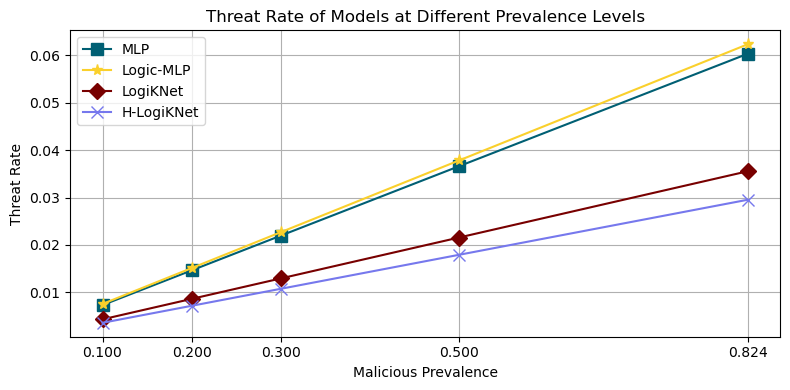

In [9]:
import matplotlib.pyplot as plt
import numpy as np

model_attrs = {
    "mlp": {"color": "#005f73", "marker": "s", "name": "MLP"},  # square
    "logic_mlp": {"color": "#fad02c", "marker": "*", "name": "Logic-MLP"},  # star
    "logiKNet": {"color": "#780000", "marker": "D", "name": "LogiKNet"},  # diamond
    "hierarchical_logiKNet": {"color": "#7678ed", "marker": "x", "name": "H-LogiKNet"}  # x-mark
}

# plotting the real-world impact of each model
def plot_threat_rate_vs_prevalence(real_world_impact, prevalence_list):
    """
    Plot the real-world impact of each model based on different prevalence values.
    
    Args:
        real_world_impact: Dictionary with real-world impact for each model
        prevalence_list: List of prevalence values used in the analysis
    """
    plt.figure(figsize=(8, 4))
    
    for model_name in model_attrs.keys():
        impact_vals = [real_world_impact[p][model_name] for p in prevalence_list]
        plt.plot(prevalence_list, impact_vals,
                 label=model_attrs[model_name]["name"],
                 color=model_attrs[model_name]["color"],
                 marker=model_attrs[model_name]["marker"],
                 markersize=8)

    plt.title("Threat Rate of Models at Different Prevalence Levels")
    plt.xlabel("Malicious Prevalence")
    plt.ylabel("Threat Rate")
    plt.xticks(prevalence_list)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot the real-world impact of each model
plot_threat_rate_vs_prevalence(threat_rate, prevalence_list=prevalence_list)

##### 3.1 Persistent vs Intermittent Mode (malicious prevalence fixed)

In [ ]:
# Persistent Mode Analysis
# Set malicious prevalence for threat rate calculation
malicious_prevalence = 0.5
threat_rate = calculate_threat_rate(detection_failure_rate, malicious_prevalence)
print("\nThreat Rate Analysis when prevalence is 0.5 (Persistent Mode)")
print("=" * 40)
print(f"{'Model':<20} {'Threat Rate':<20}")
for model_name, impact in threat_rate.items():
    print(f"{model_name:<20} {impact:<20.4f} ({impact*100:.2f}%)")


Threat Rate Analysis when prevalence is 0.3 (Persistent Mode)
Model                Threat Rate         
mlp                  0.0366               (3.66%)
logic_mlp            0.0378               (3.78%)
logiKNet             0.0216               (2.16%)
hierarchical_logiKNet 0.0179               (1.79%)


In [11]:
def calculate_intermittent_detection_failure_rate(model, test_loader, interval):
    """
    Calculate the detection failure rate for intermittent mode based on the given interval.
    
    The intermittent algorithm is applied only to malicious cases, ignoring benign cases.
    This separates the data prevalence factor from the detection failure calculation.
    
    In intermittent mode:
    - interval=1: persistent mode, inference on every malicious sample
    - interval>1: randomly pick 1 sample from every 'interval' malicious samples for inference
    
    Missed malicious cases include:
    - Malicious samples not selected for inference (due to random sampling)
    - Malicious samples selected but incorrectly predicted as benign (class 5)
    
    Args:
        model: The model to evaluate
        test_loader: DataLoader for the test dataset
        interval: Time interval for intermittent mode (in time units)
    
    Returns:
        Detection failure rate for the given interval
    """
    model.eval()
    
    # Collect all data and labels
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            all_data.append(data)
            all_labels.append(labels)
    
    # Concatenate all batches
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Extract only malicious cases (classes 0-4, excluding Benign class 5)
    malicious_mask = all_labels != 5
    malicious_data = all_data[malicious_mask]
    malicious_labels = all_labels[malicious_mask]
    total_malicious = len(malicious_labels)
    
    if total_malicious == 0:
        return 0.0
    
    if interval == 1:
        # Persistent mode: inference on every malicious sample
        with torch.no_grad():
            logits = model(malicious_data)
            preds = torch.argmax(logits, dim=1)
        
        # Calculate missed malicious cases (malicious predicted as benign)
        missed_malicious = (preds == 5).sum().item()
        
    else:
        # Intermittent mode: randomly pick 1 sample from every 'interval' malicious samples
        np.random.seed(42)  # For reproducibility
        
        missed_malicious = 0
        
        # Process malicious samples in chunks of 'interval' size
        for start_idx in range(0, total_malicious, interval):
            end_idx = min(start_idx + interval, total_malicious)
            chunk_size = end_idx - start_idx
            
            if chunk_size == 0:
                continue
                
            # Randomly select one malicious sample from this chunk for inference
            selected_local_idx = np.random.randint(0, chunk_size)
            selected_idx = start_idx + selected_local_idx
            
            # Do inference on the selected malicious sample
            selected_data = malicious_data[selected_idx:selected_idx+1]
            with torch.no_grad():
                logits = model(selected_data)
                pred = torch.argmax(logits, dim=1)[0]
            
            # If predicted as benign (class 5), it's a missed detection
            if pred == 5:
                missed_malicious += 1
            
            # All other malicious samples in this chunk are not processed (missed)
            missed_malicious += chunk_size - 1
    
    # Calculate detection failure rate
    detection_failure_rate = missed_malicious / total_malicious
    return detection_failure_rate


# Test different intervals for each model
test_intervals = [1, 2, 3, 5]
intermittent_failure_rates = {}

for interval in test_intervals:
    intermittent_failure_rates[interval] = {}
    
    for model_name, model in model_list.items():
        failure_rate = calculate_intermittent_detection_failure_rate(model, test_loader, interval)
        intermittent_failure_rates[interval][model_name] = failure_rate


In [12]:
# Test the intermittent detection failure rate function
print("\nIntermittent Detection Failure Rate Analysis")
print("=" * 60)

for interval in intermittent_failure_rates:
    print(f"\nInterval: {interval}")
    print("-" * 50)
    print(f"{'Model':<20} {'Detection Failure':<16} {'Threat Rate':<12} {'Mode'}")
    print("-" * 50)
    
    for model_name, failure_rate in intermittent_failure_rates[interval].items():
        # Calculate the threat rate based on the detection failure rate
        threat_rate = calculate_threat_rate({model_name: failure_rate}, malicious_prevalence)[model_name]
        
        mode_str = "Persistent" if interval == 1 else "Intermittent"
        print(f"{model_name:<20} {failure_rate:<16.4f} ({failure_rate*100:.2f}%) {threat_rate:<12.4f} ({threat_rate*100:.2f}%) [{mode_str}]")


Intermittent Detection Failure Rate Analysis

Interval: 1
--------------------------------------------------
Model                Detection Failure Threat Rate  Mode
--------------------------------------------------
mlp                  0.0732           (7.32%) 0.0366       (3.66%) [Persistent]
logic_mlp            0.0757           (7.57%) 0.0378       (3.78%) [Persistent]
logiKNet             0.0431           (4.31%) 0.0216       (2.16%) [Persistent]
hierarchical_logiKNet 0.0359           (3.59%) 0.0179       (1.79%) [Persistent]

Interval: 2
--------------------------------------------------
Model                Detection Failure Threat Rate  Mode
--------------------------------------------------
mlp                  0.5351           (53.51%) 0.2675       (26.75%) [Intermittent]
logic_mlp            0.5363           (53.63%) 0.2682       (26.82%) [Intermittent]
logiKNet             0.5226           (52.26%) 0.2613       (26.13%) [Intermittent]
hierarchical_logiKNet 0.5184         

##### 4. Plot

In [1]:
import matplotlib.pyplot as plt
import numpy as np

model_attrs = {
    "mlp": {"color": "#005f73", "marker": "s", "name": "MLP"},  # square
    "logic_mlp": {"color": "#fad02c", "marker": "*", "name": "Logic-MLP"},  # star
    "logiKNet": {"color": "#780000", "marker": "D", "name": "LogiKNet"},  # diamond
    "hierarchical_logiKNet": {"color": "#7678ed", "marker": "x", "name": "H-LogiKNet"}  # x-mark
}

Creating Power vs Threat Rate Analysis Plots...


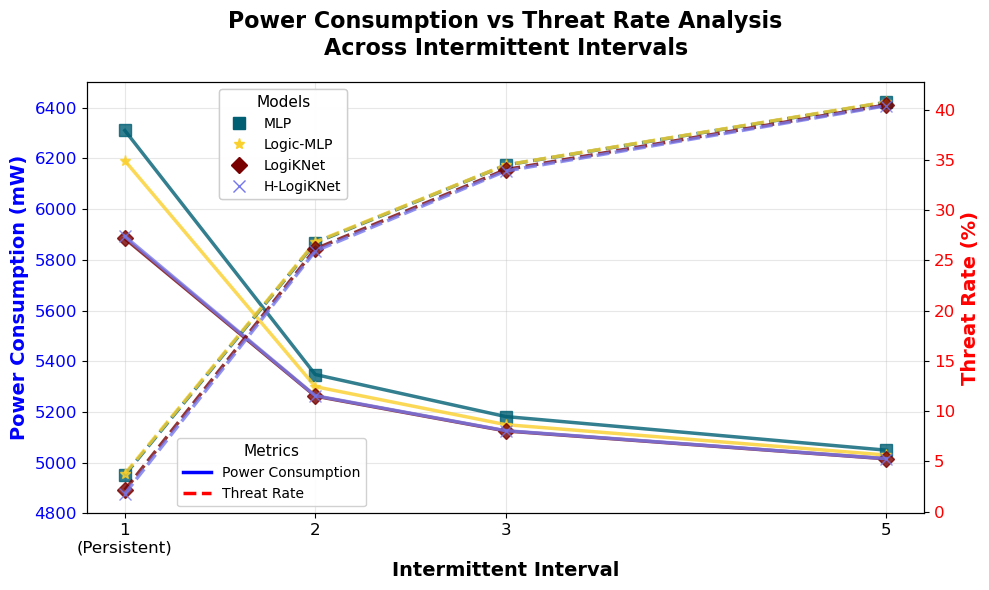


SUMMARY STATISTICS

MLP:
  Power Reduction: 6310 → 5049 mW (20.0% savings)
  Threat Rate Increase: 3.7% → 40.7% (11.1x increase)

Logic-MLP:
  Power Reduction: 6191 → 5030 mW (18.8% savings)
  Threat Rate Increase: 3.8% → 40.8% (10.8x increase)

LogiKNet:
  Power Reduction: 5884 → 5015 mW (14.8% savings)
  Threat Rate Increase: 2.2% → 40.5% (18.7x increase)

H-LogiKNet:
  Power Reduction: 5892 → 5016 mW (14.9% savings)
  Threat Rate Increase: 1.8% → 40.4% (22.6x increase)


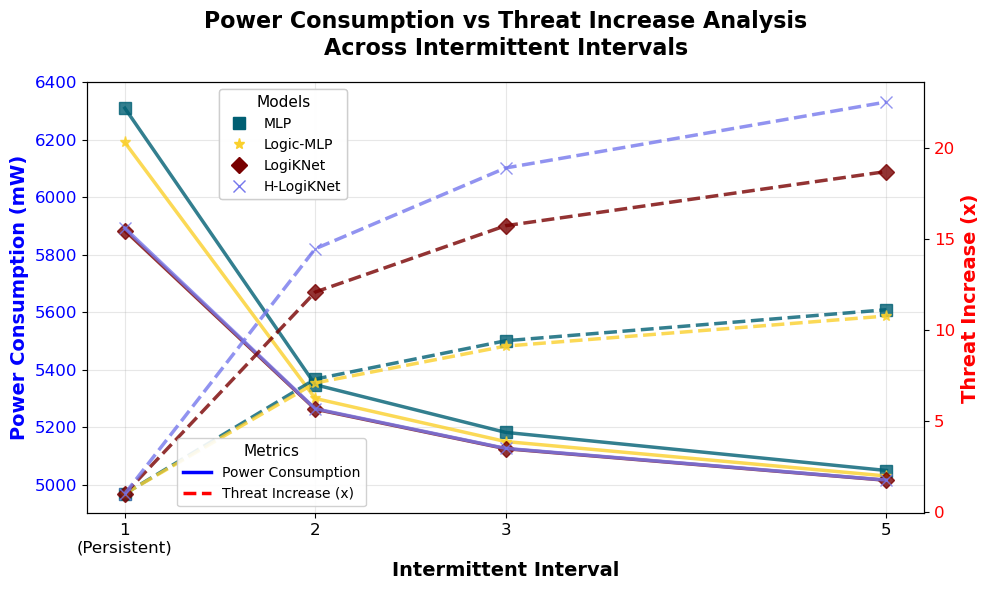

Plots already created. To recreate, restart kernel or run:
del sys._plotting_executed


In [ ]:
# ============================================================================
# DUAL Y-AXIS PLOT: POWER CONSUMPTION vs THREAT RATE
# ============================================================================
# Data from the files
intermit_intervals = [1, 2, 3, 5]
    
# Power consumption data (mW) from power_consumption_analysis.txt
power_data = {
    'mlp': [6310.30, 5347.61, 5181.74, 5049.04],
    'logic_mlp': [6190.90, 5299.78, 5149.85, 5029.91],
    'logiKNet': [5884.20, 5262.38, 5124.92, 5014.95],
    'hierarchical_logiKNet': [5892.20, 5264.06, 5126.04, 5015.63]
}

# Threat rate data (%) from intermittent analysis results (prevalence = 0.5)
threat_data = {
    'mlp': [3.66, 26.75, 34.47, 40.72],
    'logic_mlp': [3.78, 26.82, 34.49, 40.75],
    'logiKNet': [2.16, 26.13, 34.02, 40.46],
    'hierarchical_logiKNet': [1.79, 25.92, 33.88, 40.38]
}


def create_power_vs_threat_plot():
    """Create a dual y-axis plot showing power consumption and threat rates across intermittent intervals."""
    
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot power consumption on left y-axis
    for model_name in power_data.keys():
        attrs = model_attrs[model_name]
        ax1.plot(intermit_intervals, power_data[model_name], 
                color=attrs['color'], marker=attrs['marker'], 
                linewidth=2.5, markersize=8, label=f"{attrs['name']} (Power)",
                linestyle='-', alpha=0.8)
    
    # Plot threat rate on right y-axis
    for model_name in threat_data.keys():
        attrs = model_attrs[model_name]
        ax2.plot(intermit_intervals, threat_data[model_name], 
                color=attrs['color'], marker=attrs['marker'], 
                linewidth=2.5, markersize=8, label=f"{attrs['name']} (Threat)",
                linestyle='--', alpha=0.8)
    
    # Configure left y-axis (Power)
    ax1.set_xlabel('Intermittent Interval', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Power Consumption (mW)', fontsize=14, fontweight='bold', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(4800, 6500)
    
    # Configure right y-axis (Threat Rate)
    ax2.set_ylabel('Threat Rate (%)', fontsize=14, fontweight='bold', color='red')
    ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
    
    # Configure x-axis
    ax1.set_xticks(intermit_intervals)
    ax1.set_xticklabels(['1\n(Persistent)', '2', '3', '5'])
    
    # Add title
    plt.title('Power Consumption vs Threat Rate Analysis\nAcross Intermittent Intervals', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Create model legend (first legend)
    model_handles = []
    model_labels = []
    for model_name in power_data.keys():
        attrs = model_attrs[model_name]
        # Create a handle with color and marker but no line style
        handle = plt.Line2D([0], [0], color=attrs['color'], marker=attrs['marker'], 
                           linestyle='None', markersize=8, label=attrs['name'])
        model_handles.append(handle)
        model_labels.append(attrs['name'])
    
    model_legend = ax1.legend(model_handles, model_labels, loc='upper left', bbox_to_anchor=(0.15, 1),
                             title='Models', fontsize=10, 
                             title_fontsize=11, framealpha=0.9)
    
    # Create line style legend (second legend)
    style_handles = [
        plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, 
                  label='Power Consumption'),
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, 
                  label='Threat Rate')
    ]
    style_labels = ['Power Consumption', 'Threat Rate']
    
    style_legend = ax2.legend(style_handles, style_labels, loc='lower left', bbox_to_anchor=(0.1, 0),
                             title='Metrics', fontsize=10, 
                             title_fontsize=11, framealpha=0.9)
    
    # Add the model legend back (since matplotlib only shows the last legend by default)
    ax1.add_artist(model_legend)
    
    # Add annotation for trade-off
    # ax1.annotate('Power-Security Trade-off:\nLower power → Higher threat rate', 
    #             xy=(3, 5100), xytext=(2.2, 5400),
    #             fontsize=11, ha='center', va='center',
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
    #             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    # plt.savefig('power_vs_threat_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    for model_name in power_data.keys():
        attrs = model_attrs[model_name]
        print(f"\n{attrs['name']}:")
        print(f"  Power Reduction: {power_data[model_name][0]:.0f} → {power_data[model_name][-1]:.0f} mW " +
              f"({((power_data[model_name][0] - power_data[model_name][-1]) / power_data[model_name][0] * 100):.1f}% savings)")
        print(f"  Threat Rate Increase: {threat_data[model_name][0]:.1f}% → {threat_data[model_name][-1]:.1f}% " +
              f"({(threat_data[model_name][-1] / threat_data[model_name][0]):.1f}x increase)")


def create_power_vs_threatup_plot():
    """Create a dual y-axis plot showing power consumption and threat rates across intermittent intervals."""
    
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot power consumption on left y-axis
    for model_name in power_data.keys():
        attrs = model_attrs[model_name]
        ax1.plot(intermit_intervals, power_data[model_name], 
                color=attrs['color'], marker=attrs['marker'], 
                linewidth=2.5, markersize=8, label=f"{attrs['name']} (Power)",
                linestyle='-', alpha=0.8)
    
    # Plot threat rate on right y-axis
    for model_name in threat_data.keys():
        threat_rate_up = [val / threat_data[model_name][0] for val in threat_data[model_name]]  # Calculate threat rate increase for each interval
        attrs = model_attrs[model_name]
        ax2.plot(intermit_intervals, threat_rate_up, 
                color=attrs['color'], marker=attrs['marker'], 
                linewidth=2.5, markersize=8, label=f"{attrs['name']} (Threat)",
                linestyle='--', alpha=0.8)
    
    # Configure left y-axis (Power)
    ax1.set_xlabel('Intermittent Interval', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Power Consumption (mW)', fontsize=14, fontweight='bold', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(4900, 6400)
    
    # Configure right y-axis (Threat Rate)
    ax2.set_ylabel('Threat Increase (x)', fontsize=14, fontweight='bold', color='red')
    ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
    
    # Configure x-axis
    ax1.set_xticks(intermit_intervals)
    ax1.set_xticklabels(['1\n(Persistent)', '2', '3', '5'])
    
    # Add title
    plt.title('Power Consumption vs Threat Increase Analysis\nAcross Intermittent Intervals', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Create model legend (first legend)
    model_handles = []
    model_labels = []
    for model_name in power_data.keys():
        attrs = model_attrs[model_name]
        # Create a handle with color and marker but no line style
        handle = plt.Line2D([0], [0], color=attrs['color'], marker=attrs['marker'], 
                           linestyle='None', markersize=8, label=attrs['name'])
        model_handles.append(handle)
        model_labels.append(attrs['name'])
    
    model_legend = ax1.legend(model_handles, model_labels, loc='upper left', bbox_to_anchor=(0.15, 1),
                             title='Models', fontsize=10, 
                             title_fontsize=11, framealpha=0.9)
    
    # Create line style legend (second legend)
    style_handles = [
        plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, 
                  label='Power Consumption'),
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, 
                  label='Threat Increase (x)')
    ]
    style_labels = ['Power Consumption', 'Threat Increase (x)']
    
    style_legend = ax2.legend(style_handles, style_labels, loc='lower left', bbox_to_anchor=(0.1, 0),
                             title='Metrics', fontsize=10, 
                             title_fontsize=11, framealpha=0.9)
    
    # Add the model legend back (since matplotlib only shows the last legend by default)
    ax1.add_artist(model_legend)
    
    # Add annotation for trade-off
    # ax1.annotate('Power-Security Trade-off:\nLower power → Higher threat rate', 
    #             xy=(3, 5100), xytext=(2.2, 5400),
    #             fontsize=11, ha='center', va='center',
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
    #             arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    # plt.savefig('power_vs_threat_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    

def create_efficiency_comparison_plot():
    """Create a plot showing power efficiency vs security trade-off."""
    
    # Data for interval=5 (most aggressive intermittent mode)
    models = ['MLP', 'Logic-MLP', 'LogiKNet', 'H-LogiKNet']
    power_savings = [20.0, 18.8, 14.8, 14.9]  # % savings from persistent mode
    threat_increase = [2.01, 2.27, 3.48, 3.61]  # x increase from persistent mode

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create scatter plot
    for i, model_name in enumerate(['mlp', 'logic_mlp', 'logiKNet', 'hierarchical_logiKNet']):
        attrs = model_attrs[model_name]
        ax.scatter(power_savings[i], threat_increase[i], 
                  color=attrs['color'], marker=attrs['marker'], 
                  s=100, alpha=0.7, label=attrs['name'])
        
        # Add model labels
        ax.annotate(attrs['name'], (power_savings[i], threat_increase[i]), 
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=11, fontweight='bold')
    
    # Configure plot
    ax.set_xlabel('Power Savings (%)', fontsize=14, fontweight='bold', color='green')
    ax.tick_params(axis='x', labelcolor='green')
    ax.set_ylabel('Threat Increase (x)', fontsize=14, fontweight='bold', color='orange')
    ax.tick_params(axis='y', labelcolor='orange')
    ax.set_title('Power Efficiency vs Security Trade-off\n(Intermittent Interval = 5)', 
                fontsize=16, fontweight='bold')
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add diagonal reference lines
    ax.axhline(y=2.0, color='orange', linestyle='--', alpha=0.5, label='2x Threat Increase')
    ax.axvline(x=15.0, color='green', linestyle='--', alpha=0.5, label='15% Power Savings')
    
    # Add legend
    ax.legend(loc='upper left', fontsize=10)
    
    # Set limits
    ax.set_xlim(10, 25)
    ax.set_ylim(1.5, 4.0)
    
    plt.tight_layout()
    # plt.savefig('efficiency_vs_security_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# EXECUTE PLOTTING
# ============================================================================

# Check if plotting has been executed
print("Creating Power vs Threat Rate Analysis Plots...")

# Create the main dual y-axis plot
create_power_vs_threat_plot()
create_power_vs_threatup_plot()

# Create the efficiency comparison plot
# create_efficiency_comparison_plot()
print("Plots already created. To recreate, restart kernel or run:")
print("del sys._plotting_executed")

#### 5. Power Consumption Table 